Create your environment and enter " pip install -r requirements.txt "

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset

AB_PATH = "../data/ab_data.csv"
COUNTRIES_PATH = "../data/countries.csv"

ab = pd.read_csv(AB_PATH)
ab.head()

countries = pd.read_csv(COUNTRIES_PATH)
countries.head()

# Merge datasets
df = ab.merge(countries, how='left', on='user_id')
df.columns = [c.strip().lower() for c in df.columns]
display(df)


In [ ]:

# Basic info
print(f"Original shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Check for duplicate user IDs (adjust column name as needed)
user_col = 'user_id' 
if user_col in df.columns:
    print(f"Unique users: {df[user_col].nunique()}")
    print(f"Total records: {len(df)}")
    duplicated_users = len(df) - df[user_col].nunique()
    print(f"Duplicate user records: {duplicated_users}")

# CLEANING STEPS

# 1. Remove completely duplicate rows
df = df.drop_duplicates()

# 2. Handle missing values
# Fill missing values with 0 for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Fill missing values with 'Unknown' for text columns
text_cols = df.select_dtypes(include=['object']).columns
df[text_cols] = df[text_cols].fillna('Unknown')

# Final check
print(f"\nAfter cleaning:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Save cleaned data
df.to_csv('../data/cleaned_data.csv', index=False)
print("Saved as 'cleaned_data.csv'")

Data Validation

1. Landing page consistency 
2. 50/50 Check
3. Country Balance

In [ ]:
# 1. Landing page consistency
df = pd.read_csv('../data/cleaned_data.csv')

# Check consistency between group and landing_page
control_check = df[df['group'] == 'control']['landing_page'].value_counts()
treatment_check = df[df['group'] == 'treatment']['landing_page'].value_counts()

print("Control group:")
print(control_check)
print("\nTreatment group:")
print(treatment_check)

# Remove inconsistent records
clean_df = df[~((df['group'] == 'control') & (df['landing_page'] == 'new_page') | 
               (df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))]

# Verify the cleaning worked
print("\nAfter cleaning:")
control_check_clean = clean_df[clean_df['group'] == 'control']['landing_page'].value_counts()
treatment_check_clean = clean_df[clean_df['group'] == 'treatment']['landing_page'].value_counts()

print("Control group:")
print(control_check_clean)
print("\nTreatment group:")
print(treatment_check_clean)

# Save cleaned data
df.to_csv('../data/cleaned_data.csv', index=False)
print("\nSaved as 'cleaned_data.csv'")

In [19]:
# 2. 50/50 Check
# Check group allocation ratio
group_counts = df['group'].value_counts()
group_percentages = df['group'].value_counts(normalize=True) * 100

print("Group allocation:")
print(group_counts)
print(f"\nPercentages:")
print(group_percentages)

Group allocation:
group
treatment    147278
control      147202
Name: count, dtype: int64

Percentages:
group
treatment    50.012904
control      49.987096
Name: proportion, dtype: float64


Country distribution across groups:
group    control  treatment
country                    
CA          7302       7393
UK         36841      36578
US        103059     103307

Country percentages by group:
group    control  treatment
country                    
CA         49.69      50.31
UK         50.18      49.82
US         49.94      50.06

Chi-square test for country balance:
Chi2: 1.7841, p-value: 0.4098
✓ Countries are balanced across groups


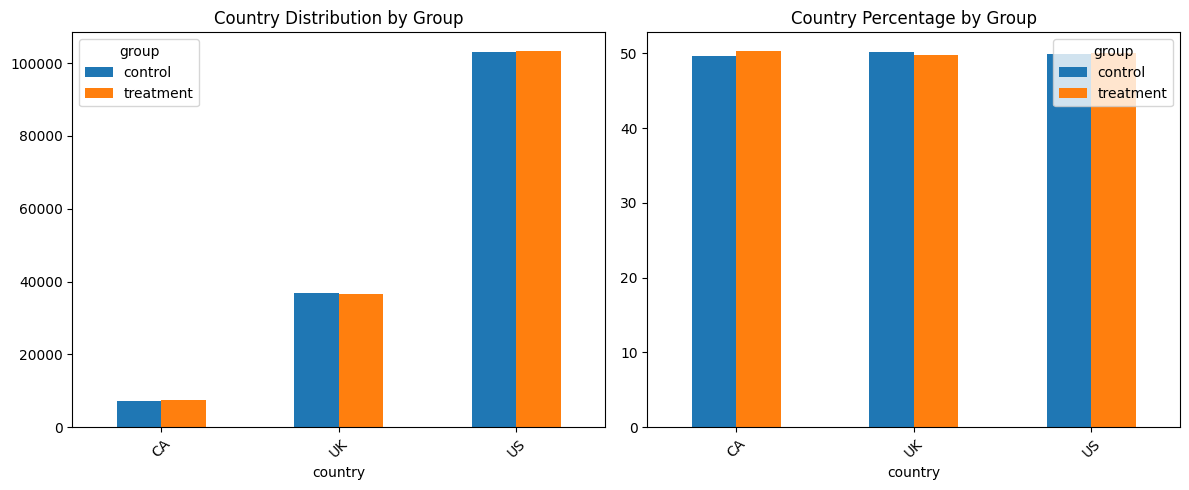

In [21]:
# 3. Country Balance
# Create contingency table for country vs group
country_crosstab = pd.crosstab(df['country'], df['group'])
print("Country distribution across groups:")
print(country_crosstab)

# Calculate percentages
country_percentages = pd.crosstab(df['country'], df['group'], normalize='index') * 100
print("\nCountry percentages by group:")
print(country_percentages.round(2))

# Chi-square test for country balance
chi2_country, p_country, dof, expected = stats.chi2_contingency(country_crosstab)
print(f"\nChi-square test for country balance:")
print(f"Chi2: {chi2_country:.4f}, p-value: {p_country:.4f}")

if p_country > 0.05:
    print("✓ Countries are balanced across groups")
else:
    print("⚠ Countries may not be balanced across groups")
    
# Visualise country distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
country_crosstab.plot(kind='bar', ax=ax[0])
ax[0].set_title('Country Distribution by Group')
ax[0].tick_params(axis='x', rotation=45)

country_percentages.plot(kind='bar', ax=ax[1])
ax[1].set_title('Country Percentage by Group')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()